# NWA suntans: look at surface flow deformation field

To do: 

- investigate seasonal evolution



In [1]:
import os

import numpy as np
#import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34334 instead
  warnings.warn(


---
## dev

- `xv`, `yv`: centroids
- `xp`, `yp`: node points
- `xe`, `ye`: edge center?
- `dg`: distance between voronoi points
- `def`: edge to face(cell) distance (Nc x maxfaces)
- `dfe`: the face(cell) to edge distance (Ne x 2)
- `df`: length of each edge segment
- `Ac`: cell area
- `Aj`: area of the triangle made up of the lines between the two edge nodes and the Voronoi point
- Edge coordinate is the intersection of the voronoi edge  and Delaunay edge
- `tx`, `ty`: edge unit vector
- `n1`, `n2`: normal unit vector
- `grad` index

- Delauney triangulation: dual structure of the Voronoi diagram.

https://team.inria.fr/titane/files/2022/11/voronoi-delaunay.pdf

In [6]:
ds, grd = nwa.load_surf()

op = grd.compute()
op["cells"] = op.cells.where( op.cells!=999999, other=-999999 )
op.suntans.Nk = np.ones(ds.Nc.size)

In [36]:
# compute gradient
eta = ds.eta.isel(time=1).values

detadx, detady = op.suntans.calc_grad(eta)
ds["detadx"] = ("Nc", detadx)
ds["detady"] = ("Nc", detady)

#detadx, detady = ds.suntans.calc_grad()
#ds["detadx"] = ("Nc", detadx)
#ds["detady"] = ("Nc", detady)

---
## store gradients - requires more workers

In [22]:
ds, grd = nwa.load_surf()

low = True
if low:
    zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
    ds = xr.open_zarr(zarr)
    ds = ds.assign_coords(**grd)

In [24]:
# in two passes to ease scheduler
ds = ds.chunk(dict(time=500, Nc=-1)).persist()

In [25]:
ds = ds.chunk(dict(time=50)).persist()

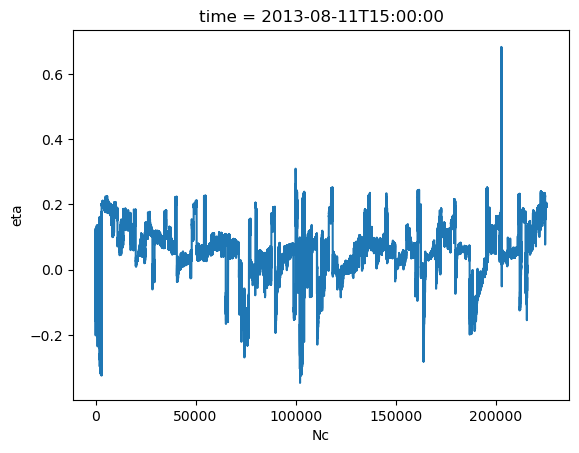

In [31]:
ds.eta.isel(time=1000).plot()

In [32]:
#ds = ds.persist()
#ds = ds[["eta"]].persist() # dev
#ds = ds[["eta"]].isel(time=slice(0,500)).persist() # dev
#ds = ds.isel(time=slice(0,500)).persist() # dev

op = grd.compute()
op["cells"] = op.cells.where( op.cells!=999999, other=-999999 )
#op = op.chunk(dict(Nc=-1))
op.suntans.Nk = np.ones(ds.Nc.size)

In [33]:
#cluster.scale(jobs=5)
#cluster.rebalance()

In [34]:
def _grad(v):
    return op.suntans.calc_grad(v)

def grad(da):
    """ compute """

    #da = da.chunk(dict(Nc=-1))
    # op is rechunked outsize
    
    gx, gy = xr.apply_ufunc(_grad, da,
                            input_core_dims=(["Nc"],),  #["Nc", "Np", "numsides"]
                            output_core_dims=[["Nc"], ["Nc"]], 
                            output_dtypes=(float, float),
                            dask="parallelized", vectorize=True,
                           )

    scale_x = 111e3*np.cos(np.pi/180*da.yv)
    scale_y = 111e3
        
    gx = gx.rename("d"+da.name+"dx")/scale_x
    gy = gy.rename("d"+da.name+"dy")/scale_y
    
    return gx, gy

In [35]:
# dev
#ds["detadx"], ds["detady"] = grad(ds.eta)
#ds_grad = ds.drop(["eta",])
#ds_grad = ds_grad.persist()

In [36]:
ds["detadx"], ds["detady"] = grad(ds.eta)
#
ds["dudx"], ds["dudy"] = grad(ds.uc)
ds["dvdx"], ds["dvdy"] = grad(ds.vc)
#ds["vorticity"] = ds["dvdx"] - ds["dudy"]
#ds["divergence"] = ds["dudx"] + ds["dvdy"]
#
ds["dtempdx"], ds["dtempdy"] = grad(ds.temp)

ds_grad = ds.drop(["eta", "temp", "uc", "vc"])

In [37]:
# rechunk
ds_grad = ds_grad.chunk(dict(time=745, Nc=2000))

In [ ]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")

if low:
    zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")

ds_grad.to_zarr(zarr, mode="w")

---
## make some plots

In [17]:
ds, grd = nwa.load_surf()

#zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
#ds = xr.open_zarr(zarr)
#ds = ds.assign_coords(**grd)

In [18]:
# reload
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")
dsg = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")
dsg_low = xr.open_zarr(zarr)

In [19]:
# select snapshot
it = 1000
_ds = dsg.isel(time=it).compute()
_ds_low = dsg_low.isel(time=it).compute()
t = str(da.time.dt.strftime("%Y/%m/%d %H:%M").values)

da = (_ds["dvdx"] - _ds["dudy"])/pin.geo.coriolis(_ds.yv)
da_low = (_ds_low["dvdx"] - _ds_low["dudy"])/pin.geo.coriolis(_ds.yv)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

Text(0.5, 1.0, 'low - relative vorticity / f, t:2013/08/11 15:00')

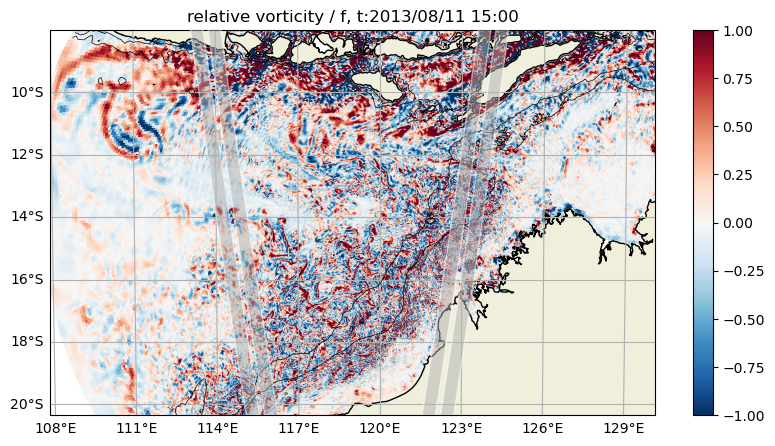

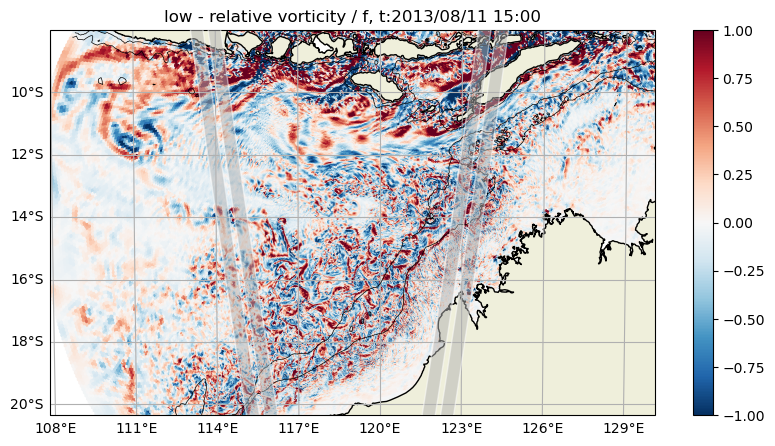

In [42]:
zoom = "large"

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu_r', vmin=-1., vmax=1., crs=crs)
ax.set_title("relative vorticity / f, t:"+t)

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da_low, cmap='RdBu_r', vmin=-1., vmax=1., crs=crs)
ax.set_title("low - relative vorticity / f, t:"+t)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

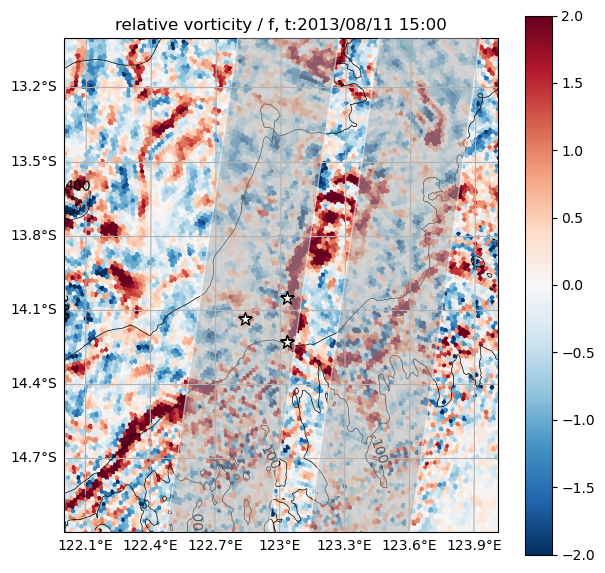

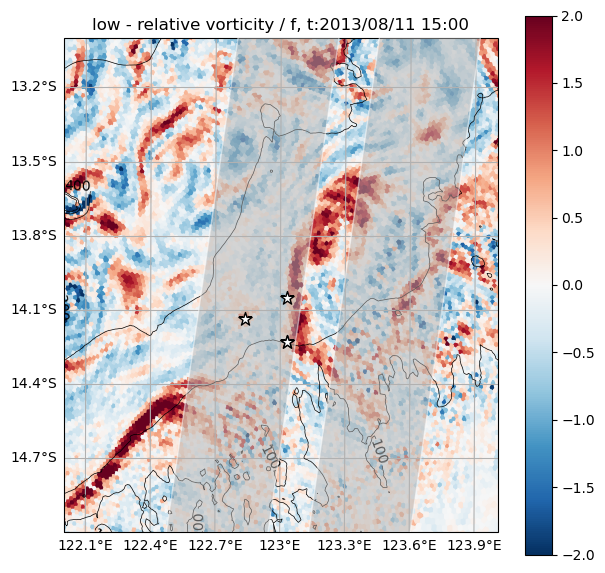

In [44]:
zoom = "cp"

vmax=2.

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu_r', vmin=-vmax, vmax=vmax, crs=crs)
ax.set_title("relative vorticity / f, t:"+t)
nwa.plot_moorings(ax, zorder=30, s=100)

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da_low, cmap='RdBu_r', vmin=-vmax, vmax=vmax, crs=crs)
ax.set_title("low - relative vorticity / f, t:"+t)
nwa.plot_moorings(ax, zorder=30, s=100)

Text(0.5, 0, 'relative vorticity / f')

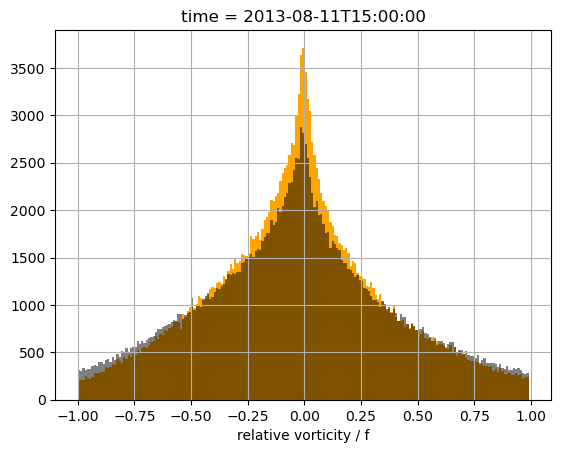

In [39]:
fig, ax = plt.subplots(1,1)
da_low.plot.hist(ax=ax, bins=np.arange(-1,1,.01), color="orange");
da.plot.hist(ax=ax, bins=np.arange(-1,1,.01), color="k", alpha=.5);
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid()
ax.set_xlabel("relative vorticity / f")

In [40]:
da.std()

<xarray.DataArray ()>
array(0.72681685)
Coordinates:
    time     datetime64[ns] 2013-08-11T15:00:00

In [41]:
da_low.std()

<xarray.DataArray ()>
array(0.56779846)
Coordinates:
    time     datetime64[ns] 2013-08-11T15:00:00

---

In [41]:
cluster.close()